### Setting Up the Environment

In [2]:
# Goal: build CNN in PyTorch to recognize MNIST (70k images of handwritten digits)
# 60k for training, 10k for testing
# grayscale, 28x28 pixels, centered

#two steps:
# 1) Feature engineering / preprocessing – turn our images into something that the algorithm can more efficiently interpret
# 2) Classification – train the algorithm to map our images to the given classes and understand the underlying relationship

import torch # PyTorch: deep learning framework w/ dynamic execution graphs
print(torch.__version__) # View version
import torchvision # allows us to load dataset MNIST
import torchvision.transforms as transforms # common image transforms 
import torchvision.datasets as datasets 

1.7.0


### Preparing the Dataset

In [3]:
# number of times looping over training set

n_epochs = 3 

# propogates 64 samples at a time, until 64k is reached. Faster and requires
# less energy than training all samples at once

batch_size_train = 64 
batch_size_test = 1000

# learning_rate and momentum are hyperparameters for the optimizer

learning_rate = 0.01
momentum = 0.5 # added to stochastic gradient descent to accelerate grad vector in the right direction (optimization algo)

log_interval = 10 # print out results at regular intervals

# must set seed for anything using random number generation

random_seed = 1

# disables cuDNN non-deterministic algos

torch.backends.cudnn.enabled = False 

# sets seed of rand generator to fixed val, so results are reproducible each epoch

torch.manual_seed(random_seed) 

In [4]:
# 0.1307 is mean of all pixel vals in dataset
# 0.3081 is stdev of all pixel vals

# stored in the data folder of jupyter
# converts PIL or ndarray to tensor (n-dimensional array which can function on CPU or GPU)
# shuffle to prevent model overfitting to training data

train_loader = torch.utils.data.DataLoader(datasets.MNIST(root='./data', train=True, download=True,transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])), batch_size=batch_size_train, shuffle=True)
print(len(train_loader)) #total MNIST size / batch size

test_loader = torch.utils.data.DataLoader(datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])), batch_size=batch_size_test, shuffle=True)
print(len(test_loader))

938
10


### Examples

In [5]:
# enumerate returns count (like index) and associated value. Can set starting count (e.g. start at 1, 2...)

examples = enumerate(test_loader) 

# example data and example target (ground truth) both returned as a tuple
batch_idx, (example_data, example_targets) = next(examples) 

# below output means one test data batch is tensor with 1000 examples of 28x28 pxs in greyscale (1)

example_data.shape 


torch.Size([1000, 1, 28, 28])

### Plot some examples

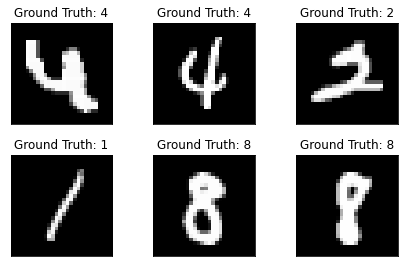

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt

for i in range(6):
    plt.subplot(2,3,i+1) # 2 rows, 3 cols
    plt.tight_layout() # fits subplots into figure areas
    
    #display data as image in colormap = grayscale
    #what does the [i][0] mean?
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none') 
    
    # title takes into account index example_target matching each example_data
    plt.title("Ground Truth: {}".format(example_targets[i]))
    #no ticks
    plt.xticks([])
    plt.yticks([])
    
#below explictly needed when creating a figure object from subplots w/ mult axis

fig = plt.figure()

### Building the Network

In [7]:
import torch.nn as nn #contains trainable params
import torch.nn.functional as F #contains activation and loss functions (purely functional)
import torch.optim as optim # package with optim algorithms

In [8]:
# use 2, 2D conv layers followed by 2 linear layers
# for regularization, use 2 dropout layers

# Create Net class which inherits from nn.Module master class and contains one class method, forward()
# forward computes forward step of CNN, including preprocessing

class Net(nn.Module):
    def __init__(self):
        
        # Define internal functions to rep layers of the net, which are called during forward pass
        # Super creates subclass which inherits attribute of the parent class (multiple inheritance, nn.Module)
        
        super(Net, self).__init__()

        # (in_channels, out_channels, kernel_size) – applies convolution
        # Conv - filtering via kernel sliding to create feature map (pixels*filter)
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        
        # during training, some layers are randomly dropped out. Model must learn to work with sparse data, and this prevents overfitting
        self.conv2_drop = nn.Dropout2d() 
        
        # (in_features, out_features) – fully connected layer (multiply inputs by learned weights)
        #this nn.Linear is the forward pass
        self.fc1 = nn.Linear(320, 50) # (20*4*4, 50), 20 is conv2 output
        self.fc2 = nn.Linear(50, 10)


    def forward(self, x): #forward pass defines way compute output w/ layers and funcs
        
        # ReLU - rectified linear unit, adds non-linearlity by converting all -1 pixel vals to 0 (so activation function only goes from 0-1, not -1-1)
        # Added since forward pass is linear, so this could approx underlying non-linear data
        
        # Max pooling - pass over sections of image and "pool" into highest val
        # Can reduce size of feature set going into NN
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # Reshape data to input to the input layer of the NN
        x = x.view(-1, 320)
        
        # Compute activation of first fully connected layer
        x = F.relu(self.fc1(x))
        
        # some layers randomly dropped out to prevent overfitting
        x = F.dropout(x, training=self.training)
        
        # Compute second fully connected layer
        x = self.fc2(x)
        
        #softmax - activation function which converts vector of numbers into vector of probabilities 
        # Activation function - eqn to determine output of NN
        return F.log_softmax(x) 

In [9]:
network = Net() #initialize the network and optimizer

#SGD is an optimizer which occurs after each batch
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum= momentum)

### Training the Model

In [10]:

# Loading indv batches handled by DataLoader

# Printouts to keep track of progress
# Initial definitions of lists 
# Losses - difference btwn predicitons and true labels for each sample
# Goes at same time as train_counter
train_losses = []

# List for every 640 samples will check and append due to if
# These are in the graph
train_counter = []

# Reported at same time as test_counter (after each epoch) so have same length
test_losses = []

# i goes up to 8 (# of epochs) and mults by len samples in each epoch (total number of samples)
# Data set split into batches, each epoch sees all batches

# Ex: if 3 epochs, datatset had 5 samples, test counter would print 0,5,10,15 and i would be 0,1,2,3
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs +1)]

#Iterate over all trianing data once per epoch

# Train is a function which takes epoch data as input
def train(epoch):
    network.train() # Switch to training mode to calc loss and optimize
    #enumerate function itself gives batch_idx
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # Manually set gradients to 0 since PyTorch default accumulates gradients and we want to recalc after each loop
        optimizer.zero_grad()
        
        # Output of network function is forward pass prediction
        output = network(data)
        
        # Compute negative loss likelihood between output and GT label
        loss = F.nll_loss(output, target)
        
        # Calcs grads to optimize NN
        loss.backward()
        
        # Propogate new set of grads back into network's params
        # Adjusts param weights of NN according to gradients
        optimizer.step()
        
        # batch size is 64, so log_interval*batch size = 640 - printout happens every 640 samples
        # When remainder is zero
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
            
            # Will also append loss to train losses list
            train_losses.append(loss.item())
            
            # And calcullates which sample you are at (prev epoch+current progress into next epoch)
            # Adds result to train counter list
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

            #.state_dict() save and load internal state
            # Could call load_state_dict to continue training from previously saved
            torch.save(network.state_dict(), 'model.pth') 
            torch.save(optimizer.state_dict(), 'optimizer.pth')
            # Files stored in jupyter
            

### Test Loop

In [11]:
# sum up test loss and keep track of correctly classified digits to compute network accuracy

# Function test
def test(): 
    network.eval() # Changes mode to test
    test_loss = 0
    correct = 0
    
    # no_grad context manager avoids storing computations done producing output of NN in computation graph
    
    # += means adds for each loop to previous (same as a = a + new)
    
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data) # output gives array with probabilities of predictions (each item)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sums up all test losses
            pred = output.data.max(1, keepdim=True)[1] # Pred is chosen according to NN says has highest prob from output
            # .sum means if correct gives 1, if not gives 0
            correct += pred.eq(target.data.view_as(pred)).sum() # Now checks if pred matches target
        test_loss /= len(test_loader.dataset) # Avg test loss
        test_losses.append(test_loss) # Appends averages
        
        # Substitutes anything after format into curly brackets in print
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0F}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

In [12]:
# Looping over n_epochs to eval model with randomly initialized params

test() # just a test to show NN function before training
for epoch in range(1, n_epochs + 1):
    train(epoch) # output is the multiple lines
    test() #output is only one lines

<ipython-input-8-9abd7d5f7922>:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/jbalowski1459/anaconda3/envs/MSNE_CS/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3089, Accuracy: 674/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.368649
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.298366
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.294433
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.260970
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.295451
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.239506
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.274136
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.225711
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.168033
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.138118
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.061368
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.945130
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.949193
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.750879
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.642634
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.585531
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.416778
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.314596
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.256788
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.537450
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.273124
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.440350
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.323490
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.403446
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.328784
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.305339
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.289879
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.343214
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.166507
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.329770
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.271235
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.335641
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.214075
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.588666
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.500673
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.377902
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.423132
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.482833
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.352499


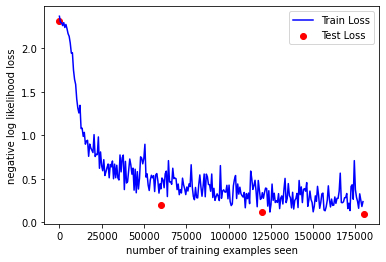

<Figure size 432x288 with 0 Axes>

In [13]:

plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

fig = plt.figure()
# test loss - measure of error encountered while predicting test cases
# train loss - measure of error encountered while training

In [14]:
with torch.no_grad():
    output = network(example_data) # just quick example to see intuitively

<ipython-input-8-9abd7d5f7922>:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


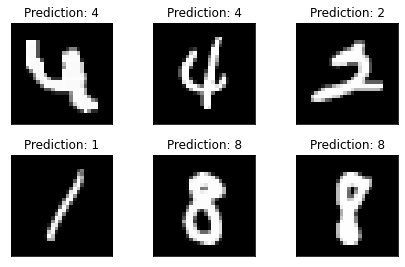

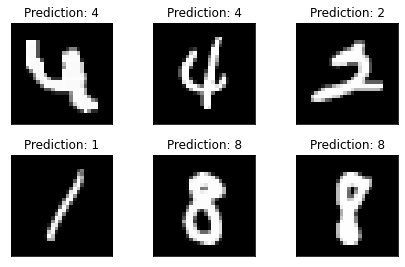

In [15]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
fig 

### Continued Training from Checkpoints

In [16]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)


In [17]:
# Checkpoint has saved data, so don't have to start over

network_state_dict = torch.load('model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('optimizer.pth') # these files have weights from earlier saved
continued_optimizer.load_state_dict(optimizer_state_dict)


In [18]:
for i in range(4,9):
    test_counter.append(i*len(train_loader.dataset))
    train(i)
    test()

<ipython-input-8-9abd7d5f7922>:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.675229
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.201320
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.177006
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.324096
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.192962
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.239860
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.247139
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.323306
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.221996
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.277183
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.306056
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.274782
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.187950
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.332099
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.131845
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.283853
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.150553
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.411381
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.253669
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.360811
Train Epoch: 4 [12800/60000 (

Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.212255
Train Epoch: 5 [45440/60000 (76%)]	Loss: 0.156328
Train Epoch: 5 [46080/60000 (77%)]	Loss: 0.139911
Train Epoch: 5 [46720/60000 (78%)]	Loss: 0.104192
Train Epoch: 5 [47360/60000 (79%)]	Loss: 0.181890
Train Epoch: 5 [48000/60000 (80%)]	Loss: 0.226523
Train Epoch: 5 [48640/60000 (81%)]	Loss: 0.220654
Train Epoch: 5 [49280/60000 (82%)]	Loss: 0.234741
Train Epoch: 5 [49920/60000 (83%)]	Loss: 0.385243
Train Epoch: 5 [50560/60000 (84%)]	Loss: 0.156538
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.224296
Train Epoch: 5 [51840/60000 (86%)]	Loss: 0.232221
Train Epoch: 5 [52480/60000 (87%)]	Loss: 0.296779
Train Epoch: 5 [53120/60000 (88%)]	Loss: 0.124059
Train Epoch: 5 [53760/60000 (90%)]	Loss: 0.277374
Train Epoch: 5 [54400/60000 (91%)]	Loss: 0.141806
Train Epoch: 5 [55040/60000 (92%)]	Loss: 0.394075
Train Epoch: 5 [55680/60000 (93%)]	Loss: 0.150280
Train Epoch: 5 [56320/60000 (94%)]	Loss: 0.210798
Train Epoch: 5 [56960/60000 (95%)]	Loss: 0.376133


Train Epoch: 7 [28800/60000 (48%)]	Loss: 0.130892
Train Epoch: 7 [29440/60000 (49%)]	Loss: 0.128358
Train Epoch: 7 [30080/60000 (50%)]	Loss: 0.170730
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.182025
Train Epoch: 7 [31360/60000 (52%)]	Loss: 0.520806
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.138741
Train Epoch: 7 [32640/60000 (54%)]	Loss: 0.135825
Train Epoch: 7 [33280/60000 (55%)]	Loss: 0.258551
Train Epoch: 7 [33920/60000 (57%)]	Loss: 0.151667
Train Epoch: 7 [34560/60000 (58%)]	Loss: 0.197507
Train Epoch: 7 [35200/60000 (59%)]	Loss: 0.139780
Train Epoch: 7 [35840/60000 (60%)]	Loss: 0.226226
Train Epoch: 7 [36480/60000 (61%)]	Loss: 0.149037
Train Epoch: 7 [37120/60000 (62%)]	Loss: 0.093356
Train Epoch: 7 [37760/60000 (63%)]	Loss: 0.157191
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.048980
Train Epoch: 7 [39040/60000 (65%)]	Loss: 0.161345
Train Epoch: 7 [39680/60000 (66%)]	Loss: 0.209658
Train Epoch: 7 [40320/60000 (67%)]	Loss: 0.159801
Train Epoch: 7 [40960/60000 (68%)]	Loss: 0.132315


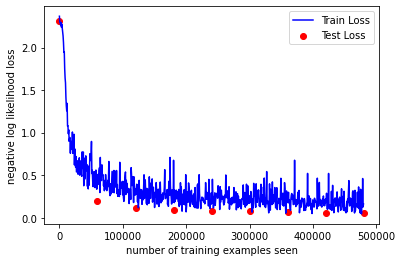

<Figure size 432x288 with 0 Axes>

In [19]:
plt.plot(train_counter, train_losses, color='blue')

# Red dots rep number of trained samples after each epoch (9)
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig = plt.figure()

# test loss - measure of error encountered while predicting test cases
# train loss - measure of error encountered while training

# In reality, there are 640 samples btwn each blue point on graph, but compacted

In [20]:
print(train_counter)
print(test_counter)

[0, 640, 1280, 1920, 2560, 3200, 3840, 4480, 5120, 5760, 6400, 7040, 7680, 8320, 8960, 9600, 10240, 10880, 11520, 12160, 12800, 13440, 14080, 14720, 15360, 16000, 16640, 17280, 17920, 18560, 19200, 19840, 20480, 21120, 21760, 22400, 23040, 23680, 24320, 24960, 25600, 26240, 26880, 27520, 28160, 28800, 29440, 30080, 30720, 31360, 32000, 32640, 33280, 33920, 34560, 35200, 35840, 36480, 37120, 37760, 38400, 39040, 39680, 40320, 40960, 41600, 42240, 42880, 43520, 44160, 44800, 45440, 46080, 46720, 47360, 48000, 48640, 49280, 49920, 50560, 51200, 51840, 52480, 53120, 53760, 54400, 55040, 55680, 56320, 56960, 57600, 58240, 58880, 59520, 60000, 60640, 61280, 61920, 62560, 63200, 63840, 64480, 65120, 65760, 66400, 67040, 67680, 68320, 68960, 69600, 70240, 70880, 71520, 72160, 72800, 73440, 74080, 74720, 75360, 76000, 76640, 77280, 77920, 78560, 79200, 79840, 80480, 81120, 81760, 82400, 83040, 83680, 84320, 84960, 85600, 86240, 86880, 87520, 88160, 88800, 89440, 90080, 90720, 91360, 92000, 9264